In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [10]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [29]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) * (2/fan_in)**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, num_features, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.training = True
        self.momentum = momentum
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.running_var = torch.ones(num_features, requires_grad=False)
        self.running_mean = torch.zeros(num_features, requires_grad=False)


    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dims = 0
            elif x.ndim == 3:
                dims = (0,1)
            x_mean = x.mean(dims, keepdim=True)
            x_var = x.var(dims, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        self.out = ((x - x_mean)/(torch.sqrt(x_var + self.eps))) * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = ((1-self.momentum) * self.running_mean) + (self.momentum * x_mean)
                self.running_var = ((1-self.momentum) * self.running_var) + (self.momentum * x_var)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __init__(self):
        pass
    def __call__(self, x):
        self.out = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for lay in self.layers:
            x = lay(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]    

In [ ]:
n_embd = 10
n_hidden = 300
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(8), Linear(n_embd*8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


32997


In [33]:
max_steps = 200001
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200001: 3.2889
  10000/ 200001: 2.3911
  20000/ 200001: 2.0554
  30000/ 200001: 2.3085
  40000/ 200001: 1.8596
  50000/ 200001: 2.4202
  60000/ 200001: 2.0962
  70000/ 200001: 2.1977
  80000/ 200001: 2.0095
  90000/ 200001: 1.9650
 100000/ 200001: 2.3250
 110000/ 200001: 2.1262
 120000/ 200001: 1.8018
 130000/ 200001: 1.7653
 140000/ 200001: 1.7988
 150000/ 200001: 1.7346
 160000/ 200001: 1.9042


KeyboardInterrupt: 

In [34]:
logits = model(Xdev)
val_loss = F.cross_entropy(logits, Ydev)
loss, val_loss

(tensor(1.8190, grad_fn=<NllLossBackward0>),
 tensor(2.0171, grad_fn=<NllLossBackward0>))

In [31]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  1,  9, 14],
        [ 0,  0,  0,  0,  0,  0, 12,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 16]])

In [32]:
for i in model.layers:
    print (f"model {i} has shape {i.out.shape}")

model <__main__.Embedding object at 0x0000014E2F4DA660> has shape torch.Size([4, 8, 10])
model <__main__.Flatten object at 0x0000014E2F4DA3C0> has shape torch.Size([4, 80])
model <__main__.Linear object at 0x0000014E2F4D9FD0> has shape torch.Size([4, 300])
model <__main__.BatchNorm1d object at 0x0000014E300BD2B0> has shape torch.Size([4, 300])
model <__main__.Tanh object at 0x0000014E300BCEC0> has shape torch.Size([4, 300])
model <__main__.Linear object at 0x0000014E2FD9BB10> has shape torch.Size([4, 27])


In [49]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x=x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

In [ ]:
n_hidden = 68
n_embd = 10
model1 = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
#    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model1.layers[-1].weight *= 0.1

parameters = model1.parameters()

print (sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

max_steps = 200001
batch_size = 32
lossi1 = []


for layer in model1.layers:
    print(layer.__class__.__name__, " : ", tuple(layer.out.shape))

22397
      0/ 200001: 3.2968
  10000/ 200001: 2.0319
  20000/ 200001: 1.5777
  30000/ 200001: 1.9810
  40000/ 200001: 2.1940
  50000/ 200001: 2.2926
  60000/ 200001: 2.1542


KeyboardInterrupt: 

In [57]:
lossi = lossi[:-2]
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model1(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi1.append(loss.log10().item())
    # break


      0/ 200001: 2.2192
  10000/ 200001: 1.6290
  20000/ 200001: 1.6580
  30000/ 200001: 2.1053
  40000/ 200001: 1.6922
  50000/ 200001: 1.8925
  60000/ 200001: 1.8949
  70000/ 200001: 2.3453
  80000/ 200001: 2.1119
  90000/ 200001: 1.6636
 100000/ 200001: 2.1494
 110000/ 200001: 2.4947
 120000/ 200001: 2.0126
 130000/ 200001: 2.2398
 140000/ 200001: 1.8899
 150000/ 200001: 1.7433
 160000/ 200001: 1.8599
 170000/ 200001: 1.6518
 180000/ 200001: 1.7746
 190000/ 200001: 1.8506
 200000/ 200001: 1.9929


(tensor(1.9929, grad_fn=<NllLossBackward0>),
 tensor(2.0280, grad_fn=<NllLossBackward0>))

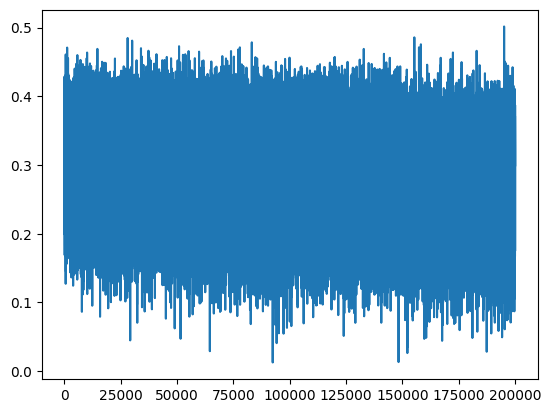

In [61]:
plt.plot(lossi1[-200000:])
for layer in model1.layers:
    layer.training = False
logit_dev = model1(Xdev)
loss_dev = F.cross_entropy(logit_dev, Ydev)
loss, loss_dev

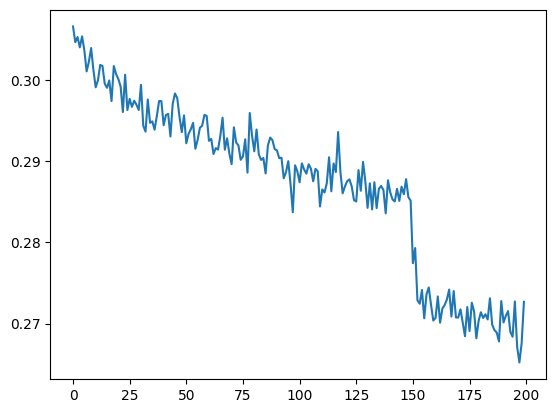

In [63]:
loss1i = torch.tensor(lossi1[-200000:]).view(-1, 1000).mean(1, keepdim=True)
plt.plot(loss1i)